<a href="https://colab.research.google.com/github/soulayman-al-abdallah/ML-Petro-well-log-lithology/blob/main/3_Classification_lithology_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lithology classification** - CatBoost
-----




Since the **total.df** is ready with filled NPHI values, we will start the **predictive modeling of the geological lithology**, represented with the **LITHOLOGY_GEOLINK**.



---



---



---



# Importing Modules and Dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time
import multiprocessing
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
total_df = pd.read_csv('/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/total_df.csv.gz', compression='gzip')
total_df.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK
0,1150.763794,13.071999,0.463152,1.970,85.510208,95.029999,3.951845,1.696892,NaN
1,1150.916260,13.155000,0.503288,1.951,91.014000,114.057999,2.285331,1.483686,NaN
2,1151.068604,13.819000,0.528165,1.934,101.687447,115.072998,1.652506,1.257905,NaN


## Class Balance of LITHO

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

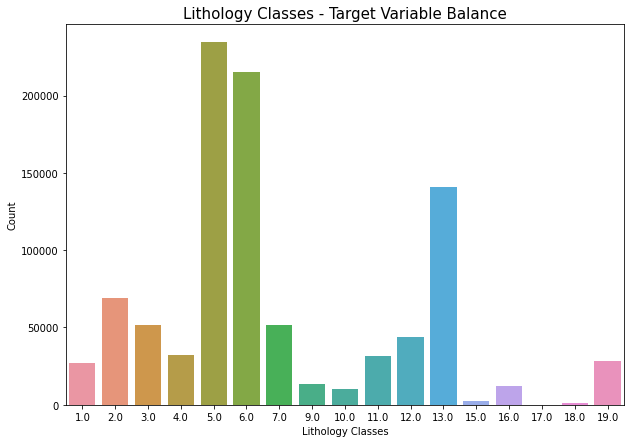

In [6]:
#target variable classes balance
plt.figure(figsize=(10,7))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)

In [7]:
#what do these values mean in terms of lihology

file_path = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/litho_code.csv.gz'

litho_code = pd.read_csv(file_path , compression='gzip')
litho_code[['Lithology Attribute','Abbreviation']]

,Lithology Attribute,Abbreviation
0,CrossBedded Sand,35.0
1,Anhydrite,22.0
2,Chalk,12.0
3,Gravel,36.0
4,Intrusive,23.0
5,Sandy Shale,25.0
6,Sandy Limestone,16.0
7,Breccia,31.0
8,Calcareous Shale,14.0
9,Halite,33.0




---



⚓ As per the df shown above, from the litho_code df data, we can combine the abbreviations 1,2,3 together since they're all have "Sand" as the lithology attribute, same applies to some other abbreviations...

In [8]:
total_df['LITHOLOGY_GEOLINK_NEW'] = total_df['LITHOLOGY_GEOLINK']

for code in total_df.index:

    if (total_df['LITHOLOGY_GEOLINK_NEW'][code] == 2 or total_df['LITHOLOGY_GEOLINK_NEW'][code] == 3):
        total_df['LITHOLOGY_GEOLINK_NEW'][code] = 1

    elif total_df['LITHOLOGY_GEOLINK_NEW'][code] == 6:
        total_df['LITHOLOGY_GEOLINK_NEW'][code] = 5

    elif total_df['LITHOLOGY_GEOLINK_NEW'][code] == 34:
        total_df['LITHOLOGY_GEOLINK_NEW'][code] = 33


    elif total_df['LITHOLOGY_GEOLINK_NEW'][code] == 13:
        total_df['LITHOLOGY_GEOLINK_NEW'][code] = 12

    else:
        pass

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

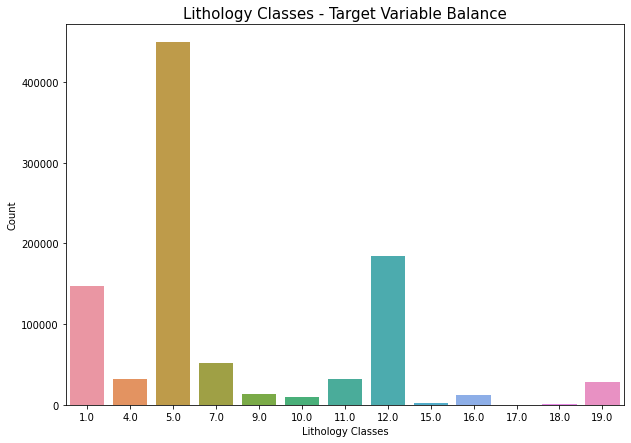

In [9]:
#visualizing the new classes balance of the target variable
plt.figure(figsize=(10,7))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK_NEW'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK_NEW'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)



---



# Feature Engineering

## Adding a column of DRDN and Acoustic Impedance values

In [10]:
total_df['DRDN'] = ((total_df['RHOB'] - 2)/0.05) - ((0.45 - total_df['NPHI'])/0.03)
total_df['AI'] = total_df['RHOB'] * (1e6/total_df['DTC']) * 0.3048

(mu_DRDN, sigma_DRDN) = stats.norm.fit(total_df[total_df.DRDN.notnull()].DRDN.values)
(mu_AI, sigma_AI) = stats.norm.fit(total_df[total_df.AI.notnull()].AI.values)


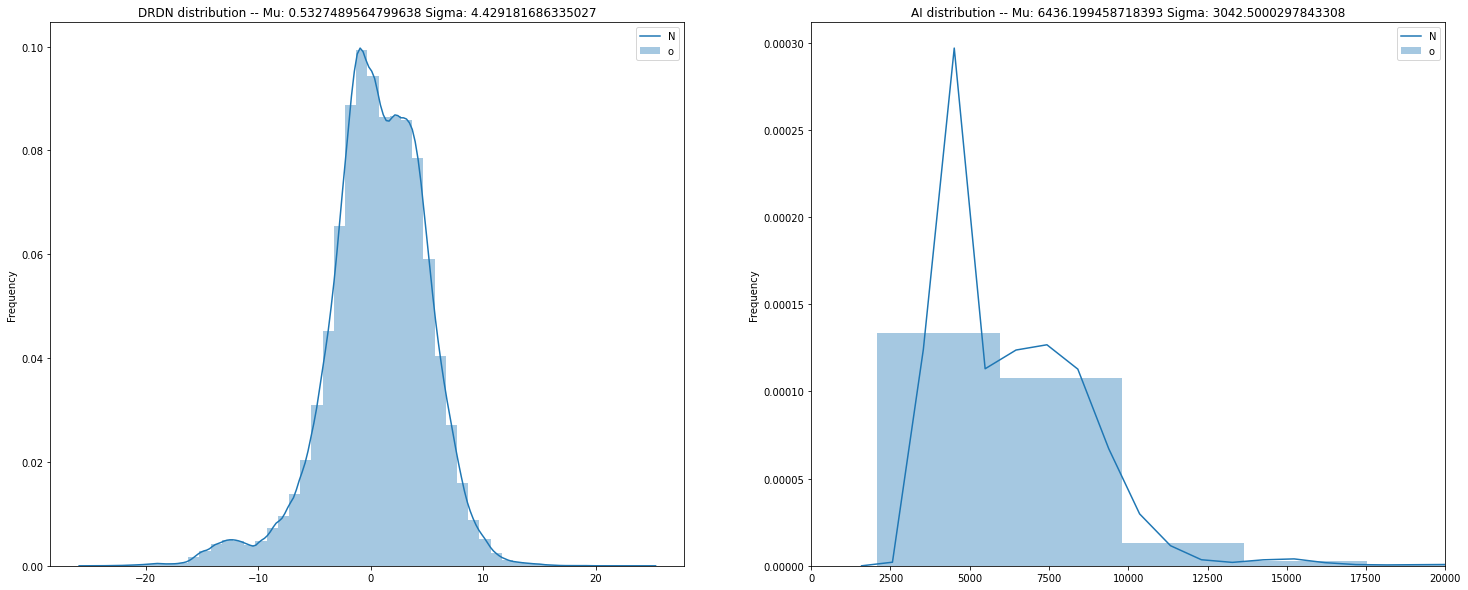

In [11]:
plt.figure(figsize=(25,10))

plt.subplot(121)
(mu, sigma) = stats.norm.fit(total_df[total_df.DRDN.notnull()].DRDN.values)
sns.distplot(total_df[total_df.DRDN.notnull()].DRDN.values)
plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('DRDN distribution -- Mu:' + ' ' + str(mu_DRDN) + ' ' + 'Sigma:' + ' ' + str(sigma_DRDN) )

plt.subplot(122)
sns.distplot(total_df[total_df.AI.notnull()].AI.values)
plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.xlim([0, 20000])
plt.title('AI distribution -- Mu:' + ' ' + str(mu_AI) + ' ' + 'Sigma:' + ' ' + str(sigma_AI) )

plt.show()

# Modeling

In [12]:
total_df.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK,LITHOLOGY_GEOLINK_NEW,DRDN,AI
0,1150.763794,13.071999,0.463152,1.970,85.510208,95.029999,3.951845,1.696892,NaN,NaN,-0.161600,6318.594301
1,1150.916260,13.155000,0.503288,1.951,91.014000,114.057999,2.285331,1.483686,NaN,NaN,0.796265,5213.705303
2,1151.068604,13.819000,0.528165,1.934,101.687447,115.072998,1.652506,1.257905,NaN,NaN,1.285500,5122.689203


In [13]:
#Data that has non-null LITHOLOGY_GEOLINK_NEW values
litho_data = total_df[pd.notnull(total_df['LITHOLOGY_GEOLINK_NEW'])].drop(columns=['LITHOLOGY_GEOLINK']) # litho2 optimum set (84.5)
print(litho_data.shape)
litho_data.head(3)

(964961, 11)


,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK_NEW,DRDN,AI
5208,1949.949585,8.570,0.317236,2.442991,67.179001,100.081024,2.389882,2.788822,12.0,4.434358,7440.206805
5209,1950.101929,8.569,0.315236,2.436997,74.393997,100.094559,2.315941,2.717173,12.0,4.247793,7420.949508
5210,1950.254394,8.574,0.313566,2.433013,75.471001,99.545738,2.241971,2.638127,12.0,4.112470,7449.664488


In [14]:
# convert to int dtype
litho_data['LITHOLOGY_GEOLINK_NEW'] = litho_data['LITHOLOGY_GEOLINK_NEW'].astype(int)
litho_data.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK_NEW,DRDN,AI
5208,1949.949585,8.570,0.317236,2.442991,67.179001,100.081024,2.389882,2.788822,12,4.434358,7440.206805
5209,1950.101929,8.569,0.315236,2.436997,74.393997,100.094559,2.315941,2.717173,12,4.247793,7420.949508
5210,1950.254394,8.574,0.313566,2.433013,75.471001,99.545738,2.241971,2.638127,12,4.112470,7449.664488




---



In [15]:
#dataset creation
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK_NEW')
Y = litho_data['LITHOLOGY_GEOLINK_NEW'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

print('Training Dataset:  ', x_train.shape, y_train.shape)
print('Test Dataset: ', x_test.shape, y_test.shape)

Training Dataset:   (482480, 10) (482480,)
Test Dataset:  (482481, 10) (482481,)


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_validate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [22]:
#Model Selection

class_pipelines = []

class_pipelines.append(('ScaledRidge', Pipeline([('Scaler', RobustScaler()),('Ridge', linear_model.RidgeClassifier())])))
class_pipelines.append(('ScaledSGDCls', Pipeline([('Scaler', RobustScaler()),('SGDCls', linear_model.SGDClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledKNNCls', Pipeline([('Scaler', RobustScaler()),('KNNCls', KNeighborsClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledDTC', Pipeline([('Scaler', RobustScaler()),('DTC', DecisionTreeClassifier())])))
class_pipelines.append(('ScaledRFC', Pipeline([('Scaler', RobustScaler()),('RFC', RandomForestClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledXGB', Pipeline([('Scaler', RobustScaler()),('XGB', XGBClassifier(tree_method='gpu_hist'))])))
class_pipelines.append(('ScaledCAT', Pipeline([('Scaler', RobustScaler()),('CAT', CatBoostClassifier(verbose=False, task_type='GPU', devices='0-2'))])))
class_pipelines.append(('ScaledLGBM', Pipeline([('Scaler', RobustScaler()),('LGBM', LGBMClassifier(n_jobs=60))])))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

results = []
names = []

for name, model in class_pipelines:

    kfold = KFold(n_splits=5)

    scorers = {'accuracy': make_scorer(accuracy_score), 
               'balanced_accuracy': make_scorer(balanced_accuracy_score), 
               'f1': make_scorer(f1_score, average='macro')}

    final_scorers = cross_validate(model, x_train, y_train, cv=kfold, scoring=scorers)
    results.append(final_scorers)
    names.append(name)
    print(name, 'Acc: ', final_scorers['test_accuracy'].mean(), '\\', final_scorers['test_accuracy'].std(), '\n')
    print(name, 'BalAcc: ', final_scorers['test_balanced_accuracy'].mean(), '\\', final_scorers['test_balanced_accuracy'].std(), '\n')
    print(name, 'F1: ', final_scorers['test_f1'].mean(), '\\', final_scorers['test_f1'].std(), '\n')
    print("===================================================")

ScaledRidge Acc:  0.5717480517327143 \ 0.0022802320325357775 

ScaledRidge BalAcc:  0.14147673412198522 \ 0.0006283257192499201 

ScaledRidge F1:  0.129697796246851 \ 0.0008020145827309508 

ScaledSGDCls Acc:  0.561389073122202 \ 0.0044021954908151015 

ScaledSGDCls BalAcc:  0.16702958609513913 \ 0.005112148334581395 

ScaledSGDCls F1:  0.15867341016302833 \ 0.0075628685329339074 

ScaledKNNCls Acc:  0.8759368263969491 \ 0.0008458391598071946 

ScaledKNNCls BalAcc:  0.7209001064678531 \ 0.006658560393867458 

ScaledKNNCls F1:  0.7528414440736075 \ 0.008222210047861401 

ScaledDTC Acc:  0.8435810810810811 \ 0.001247169127368178 

ScaledDTC BalAcc:  0.7234812620042408 \ 0.007676125517196939 

ScaledDTC F1:  0.7271168278822738 \ 0.009042018281958813 

ScaledRFC Acc:  0.9023565743657768 \ 0.0006361101193429915 

ScaledRFC BalAcc:  0.7453504205128765 \ 0.014852053902186187 

ScaledRFC F1:  0.7992343290312546 \ 0.01567772473831576 

ScaledXGB Acc:  0.6986838832697728 \ 0.0019227256421209442 



---



In [17]:
# hyperparameter tuning

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


space ={'learning_rate': hp.uniform("x.learning_rate", 0.01, 1.0),
        'max_depth': hp.choice ('x.max_depth',  np.arange(5, 11, 1, dtype=int)),
        'iterations': hp.choice ('x.iterations', np.arange(10, 1000, 20, dtype=int)),
        'bagging_temperature' : hp.uniform ('x.bagging_temperature', 0.0, 1.0),
        'border_count' : hp.choice ('x.border_count', np.arange(1, 255, 10, dtype=int)),
        'l2_leaf_reg' : hp.choice ('x.l2_leaf_reg', np.arange(2, 30, 1, dtype=int)),
        'verbose': hp.choice ('x.verbose', [False]),
        'task_type': hp.choice ('x.task_type', ['GPU']),
        'devices': hp.choice ('x.devices', ['0-3'])
    }



#  Defining Objective Function
def objective(space):
    # Instantiate the classifier
    clf = CatBoostClassifier( task_type='GPU')
        
    # Fit the classsifier
    clf.fit(RobustScaler().fit_transform(x_train), y_train)
    
    # Predict on Cross Validation data
    pred = clf.predict(RobustScaler().fit_transform(x_test))
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [18]:
X = litho_data.drop(columns=['LITHOLOGY_GEOLINK_NEW', 'DRDN', 'AI'])

Y = litho_data['LITHOLOGY_GEOLINK_NEW'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

start_time = time.time()
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)  
print(best)
print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

The result of best hyperparameters:

{'x.bagging_temperature': 0.9027421701180264, 'x.border_count': 260, 'x.devices': 0-3, 'x.iterations': 850, 'x.l2_leaf_reg': 6, 'x.learning_rate': 0.40238621723872342, 'x.max_depth': 3, 'x.task_type': 'GPU', 'x.verbose': 0}

137.5 minutes taken



---



**Training based on best parameters**

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

start_time = time.time()

best_class = CatBoostClassifier(bagging_temperature=0.9, border_count=260, devices='0-3', iterations=850, l2_leaf_reg=6, learning_rate=0.4, max_depth=6, task_type='GPU', verbose=False) # the rest of the best parameters are  the default ones
best_class.fit(RobustScaler().fit_transform(x_train), y_train)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.3 minutes taken


In [23]:
start_time = time.time()

y_predict = best_class.predict(RobustScaler().fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 
print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('F1-Score Macro: ', str(f1_score(y_test, y_predict, average='macro')))

0.0 minutes taken
Accuracy:  0.8701814164702859 

Balanced Accuracy:  0.7412331618076122
F1-Score Macro:  0.7796538008206877




---



**Feature Importance**

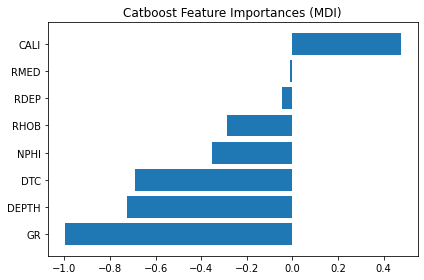

In [24]:
from catboost import Pool

train_pool = Pool(x_train, y_train)
tree_feature_importances = (best_class.get_feature_importance(train_pool, type='LossFunctionChange'))
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Catboost Feature Importances (MDI)")
fig.tight_layout()
plt.show()

**Confusion matrix**

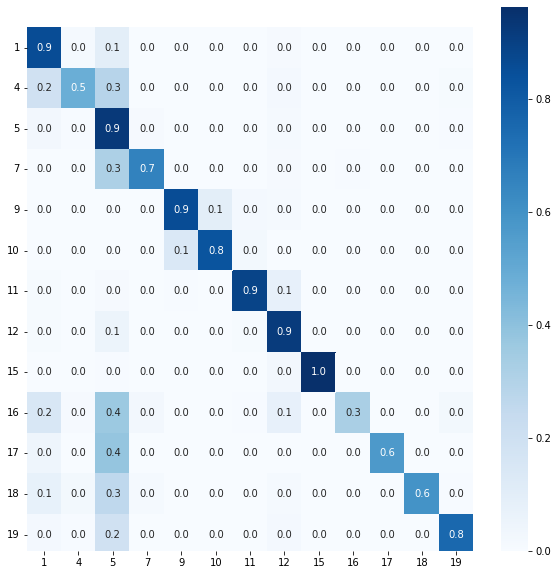

In [26]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], cmap=plt.cm.Blues, annot=True, fmt='.1f', xticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_NEW'].unique()), yticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_NEW'].unique())) # confusion matrix normalized as in Sklearn documentation

plt.yticks(rotation=0) 
ax.set_ylim(len(cf_matrix)-0.1, -0.5)

plt.show()